<a href="https://colab.research.google.com/github/farbodnm/computational-intelligence-class-9902/blob/main/G10-Semantic-Textual-Similarity/semantic_textual_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Clone from github
Clones github repo and moves them for imports.

In [1]:
!git clone https://github.com/farbodnm/computational-intelligence-class-9902.git
!mv -v /content/computational-intelligence-class-9902/G10-Semantic-Textual-Similarity/* .
!rm -R /content/computational-intelligence-class-9902

Cloning into 'computational-intelligence-class-9902'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (285/285), done.
remote: Total 349 (delta 135), reused 110 (delta 44), pack-reused 0
Receiving objects: 100% (349/349), 2.01 MiB | 9.50 MiB/s, done.
Resolving deltas: 100% (135/135), done.
renamed '/content/computational-intelligence-class-9902/G10-Semantic-Textual-Similarity/data' -> './data'
renamed '/content/computational-intelligence-class-9902/G10-Semantic-Textual-Similarity/README.md' -> './README.md'
renamed '/content/computational-intelligence-class-9902/G10-Semantic-Textual-Similarity/semantic_textual_similarity.ipynb' -> './semantic_textual_similarity.ipynb'
renamed '/content/computational-intelligence-class-9902/G10-Semantic-Textual-Similarity/utils' -> './utils'


# Config
Our config for the neural network.

In [2]:
config = {
    'model':{
        'name': 'siamese',
        'embed_size': 300,
        'batch_size': 1,
        'fc_dim': 100,
        'embed_mode': 'word',
        'learning_rate': 0.00001,
        'epochs': 7,
        'loss_mode': 'cel',
        'optimizer_mode': 'adam',
        'encoder':{
            'hidden_size': 150,
            'num_layers': 1,
            'bidirectional': False,
            'dropout': 0.0,
        },  
    },
    'embed_path': './embed.pkl'
}

# Imports

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

from utils.tokenizer import reset_word_embedding, reset_char_embedding, load_wordvec, load_charvec, save_vec, change_weights_of_mother
from utils.model import Siamese
from utils.vocabulary import vocabulary, add_to_vocabulary
from data.prepare_data import Dataset

# Data processing.
First we start by making a vocabulary of the words in all our sentences.


> then we make a vector dictionary for our vocabulary.





In [4]:
embed_path = config['embed_path']
reset_word_embedding(embed_path)
data = Dataset('/content/data/snli_1.0.txt', config)
vocab = vocabulary(data.train_set_pairs())
vocab = add_to_vocabulary(data.validation_set_pairs(), vocab)
vocab = add_to_vocabulary(data.test_set_pairs(), vocab)
vectors = load_wordvec(vocab, embed_path)
if len(vectors) == len(vocab):
  vocab_size = len(vectors)
else:
  print('Something is wrong and I can feel it.')

Dictionary file created.
Made a vocabulary of 11565 words.
Made a vocabulary with a total of 12645 words.
Made a vocabulary with a total of 13446 words.
Loaded 1 already embedded words.
Added 13446 new words to the embedding.
Loaded 13446 words to our current dictionary
Embeddings saved


# Make an embedding
Make a weight embedding ordered in the same way our vocabulary is.

In [5]:
weights = []
for word in vocab:
    weights.append(vectors[word])
embedding = nn.Embedding(vocab_size, config['model']['embed_size'])
weights_matrix = torch.from_numpy(np.array(weights)).type(torch.FloatTensor)
embedding.weight = nn.Parameter(weights_matrix, requires_grad = False)

config['vocab'] = vocab
config['embedding'] = embedding

Ready our model, loss and optimizer


In [6]:
siamese = Siamese(config)

if config['model']['loss_mode'] == 'cel':
  #variable_weight = Variable(torch.FloatTensor([1, 1.125]))
  #variable_weight = variable_weight.cuda()
  #loss_mode = torch.nn.CrossEntropyLoss(variable_weight)
  loss_mode = torch.nn.CrossEntropyLoss()
  print('Using CrossEntropyLoss loss,')
elif config['model']['loss_mode'] == 'mse':
  loss_mode = torch.nn.MSELoss()
  print('Using MeanSquaredError loss,')

learning_rate = config['model']['learning_rate']
if config['model']['optimizer_mode'] == 'sgd':
  optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, siamese.parameters()), lr=learning_rate)
  print('and sgd optimizer.')
elif config['model']['optimizer_mode'] == 'adam':
  optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, siamese.parameters()), lr=learning_rate)
  print('and adam optimizer.')

Using CrossEntropyLoss loss,
and adam optimizer.


# Start our training
Each epoch we train the model and then use the validation dataset to see our progress.



In [7]:
current_epoch = 1
epoch_num = config['model']['epochs']

train_loss_epochs = []
validation_loss_epochs = []

while current_epoch <= epoch_num:

  train_loss = []
  train_loss_all = []
  validation_loss_all = []

  print('Starting epoch', current_epoch)

  for i in range(int(data.train_set_num())):
    sentence1 = data.train_set_pairs()[i][0]
    sentence2 = data.train_set_pairs()[i][1]
    score = data.train_set_scores()[i]

    output = siamese(sentence1, sentence2)

    optimizer.zero_grad()

    if config['model']['loss_mode'] == 'cel':
      score = torch.tensor([score]).long()
      output = output.squeeze(0)

    elif config['model']['loss_mode'] == 'mse':
      score = Variable(torch.tensor(score).type(torch.FloatTensor))
      output = output.squeeze(0).squeeze(0).squeeze(0)

    #score = score.cuda()
    #output = output.cuda()
    
    loss = loss_mode(output, score)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.data)
    train_loss_all.append(loss.data)
    #train_loss.append(loss.data.cpu())
    #train_loss_all.append(loss.data.cpu())

    if ((i + 1) % 2500) == 0:
      print(i + 1, 'sentence pairs done, epoch:', current_epoch, 'and current loss:', np.mean(train_loss))
      train_loss = []

  for j in range(int(data.validation_set_num())):
    sentence1 = data.validation_set_pairs()[j][0]
    sentence2 = data.validation_set_pairs()[j][1]
    score = data.validation_set_scores()[j]

    output = siamese(sentence1, sentence2)

    optimizer.zero_grad()

    if config['model']['loss_mode'] == 'cel':
      score = torch.tensor([score]).long()
      output = output.squeeze(0)

    elif config['model']['loss_mode'] == 'mse':
      score = Variable(torch.tensor(score).type(torch.FloatTensor))
      output = output.squeeze(0).squeeze(0).squeeze(0)

    #score = score.cuda()
    #output = output.cuda()

    loss = loss_mode(output, score)

    validation_loss_all.append(loss.data)
    #validation_loss_all.append(loss.data.cpu())
    
  print('Epoch', current_epoch, 'train loss:', np.mean(train_loss_all), 'validation loss:', np.mean(validation_loss_all))
  train_loss_epochs.append(np.mean(train_loss_all))
  validation_loss_epochs.append(np.mean(validation_loss_all))
  print()

  current_epoch += 1

Starting epoch 1
2500 sentence pairs done, epoch: 1 and current loss: 1.0964208
5000 sentence pairs done, epoch: 1 and current loss: 1.0930701
7500 sentence pairs done, epoch: 1 and current loss: 1.0909145
10000 sentence pairs done, epoch: 1 and current loss: 1.086529
Epoch 1 train loss: 1.090531 validation loss: 1.077602

Starting epoch 2
2500 sentence pairs done, epoch: 2 and current loss: 1.070356
5000 sentence pairs done, epoch: 2 and current loss: 1.0631694
7500 sentence pairs done, epoch: 2 and current loss: 1.059418
10000 sentence pairs done, epoch: 2 and current loss: 1.0543097
Epoch 2 train loss: 1.0598856 validation loss: 1.048672

Starting epoch 3
2500 sentence pairs done, epoch: 3 and current loss: 1.0338955
5000 sentence pairs done, epoch: 3 and current loss: 1.0255034
7500 sentence pairs done, epoch: 3 and current loss: 1.0219929
10000 sentence pairs done, epoch: 3 and current loss: 1.0197859
Epoch 3 train loss: 1.0237654 validation loss: 1.0273947

Starting epoch 4
2500 

And a train and test loss graph.

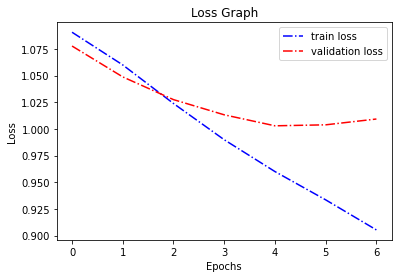

In [8]:
import matplotlib.pyplot as plt

plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_epochs, '-.', color ='blue')
plt.plot(validation_loss_epochs, '-.', color ='red')
plt.legend(['train loss', 'validation loss'], loc ='upper right')
plt.show()

And at the end we make a csv from the test set with our output.

In [9]:
import pandas as pd

csv_data = []
loss_all = []
for j in range(data.test_set_num()):
    sentence1 = data.test_set_pairs()[j][0]
    sentence2 = data.test_set_pairs()[j][1]
    score = data.test_set_scores()[j]

    output = siamese(sentence1, sentence2)

    if config['model']['loss_mode'] == 'cel':
      score = torch.tensor([score]).long()
      output = output.squeeze(0)

    elif config['model']['loss_mode'] == 'mse':
      score = Variable(torch.tensor(score).type(torch.FloatTensor))
      output = output.squeeze(0).squeeze(0).squeeze(0)

    loss = loss_mode(output, score)

    loss_all.append(loss.data)

    if config['model']['loss_mode'] == 'cel':
      output = output.squeeze(0)
      softmax = nn.Softmax(dim = 0)
      output = softmax(output)
      output = output[1] * 1 + output[2] * 2

    csv_data.append([sentence1, sentence2, score.item(), output.item(), loss.item()])

print('Test loss at the end of the training:', np.mean(loss_all))
print()
df = pd.DataFrame(csv_data, columns = ['sentence 1', 'sentence 2', 'score', 'predicted score', 'loss'])
df.to_csv('./results.csv', index=False)
print(df)
print('Results saved in a csv file, Cheers.')

Test loss at the end of the training: 1.0123202

                                             sentence 1  ...      loss
0                                         Two dogs play  ...  2.251004
1     A race car speeds away while a man covers his ...  ...  1.532061
2                       The dog is walking in the snow.  ...  1.221832
3     Three women and two men are standing at the fo...  ...  0.418764
4               A young woman with colorful clothes on.  ...  1.051119
...                                                 ...  ...       ...
3990  A photographer snaps a midair action shot of a...  ...  1.490188
3991  A woman plays in the wind, with a furry brown ...  ...  0.477017
3992  A man in a white t-shirt is holding a pair of ...  ...  1.953608
3993  Two people are sitting on a rock looking off i...  ...  0.288299
3994              A guy waxing a wooden floor with wax.  ...  0.575938

[3995 rows x 5 columns]
Results saved in a csv file, Cheers.
